In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import yaml
import os

In [16]:
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])

config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 20, 'LR': '3e-4'}


In [17]:
# may differ depending on the problem
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]) # put more transforms options here

In [18]:
# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

In [20]:
imgs, labels = next(iter(validation_loader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

Image Shapes: torch.Size([64, 3, 32, 32])
Label Shapes: torch.Size([64])


In [21]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x
    
def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
            return nn.Sequential(nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
            nn.GELU(),
            nn.BatchNorm2d(dim),
            *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim))
            for i in range(depth)],      
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(dim, n_classes))

In [22]:
from tqdm import tqdm

In [23]:
NUM_EPOCHS = int(config["NUM_EPOCHS"])
LR = float(config["LR"])

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvMixer(dim=256, depth=4, kernel_size=8,patch_size=1, n_classes=10)
model = model.to(device)

In [25]:
device

device(type='cuda')

In [26]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) #adamW was used in the paper
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, 
#         base_lr=0.0001, max_lr = LR+0.0003, cycle_momentum=False)

### Tinkering with custom schedulers 🚀

In [27]:
from torch.optim.lr_scheduler import _LRScheduler

In [32]:
class OneCycleLR(_LRScheduler):
    def __init__(self, optimizer, max_lr, total_steps, pct_warmup, last_epoch=-1):
        """_summary_

        Args:
            optimizer (_type_): _description_
            max_lr (_type_): _description_
            total_steps (_type_): _description_
            pct_warmup (_type_): _description_
            last_epoch (int, optional): _description_. Defaults to -1.
        """
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.pct_warmup = pct_warmup
        super(OneCycleLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch
        if step <= self.pct_warmup * self.total_steps:
            lr = (step / (self.pct_warmup * self.total_steps)) * self.max_lr
        else:
            lr = self.max_lr - ((step - self.pct_warmup * self.total_steps) / ((1 - self.pct_warmup) * self.total_steps)) * self.max_lr
        return [lr for _ in self.base_lrs]
    
    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        new_lr = self.get_lr()[0]  # Get the new learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr  # Update the learning rate for the optimizer


In [33]:
def linear_learning_rate_scheduler(optimizer, epoch, warmup_epochs=5, max_epochs=50, initial_lr=0.01):
    if epoch < warmup_epochs:
        lr = initial_lr * (epoch / warmup_epochs)
    else:
        lr = initial_lr * (1.0 - (epoch - warmup_epochs) / (max_epochs - warmup_epochs))
    print(f"learning rate{lr}")
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def step_warmup_step_learning_rate_scheduler(optimizer, epoch, warmup_epochs, lr_decay_epochs, lr_decay_factor, initial_lr = 0.0015):
    if epoch < warmup_epochs:
        lr = (epoch + 1) * initial_lr / warmup_epochs
    else:
        lr = initial_lr
        if epoch in lr_decay_epochs:
            lr *= lr_decay_factor

    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [34]:
@torch.no_grad()
def eval_model(model):
    """ Computing model accuracy """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss

In [35]:
EPOCHS = config["NUM_EPOCHS"]
total_steps = len(training_loader)
pct_warmup = 0.3 #warmup for 30% of training steps
scheduler = OneCycleLR(optimizer, LR, total_steps, pct_warmup)
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": []
}

In [36]:
def get_lr_show():
        for param_group in optimizer.param_groups:
                return param_group['lr']

In [38]:
loss_hist = []
for epoch in range(NUM_EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(training_loader), total=len(training_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2.0)
        # Updating parameters
        optimizer.step()
        scheduler.step()

        lrs = []
        lrs.append(scheduler.get_lr()[0])
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1} Learning rate {get_lr_show()}: loss {loss.item():.5f}. ")
             
    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])
    # evaluating model
    accuracy, valid_loss = eval_model(model)  
    print(f"Val accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)

Epoch 1 Iter 782 Learning rate 0.0: loss 1.30710. : 100%|██████████| 782/782 [01:06<00:00, 11.71it/s]                   


Val accuracy at epoch 0: 58.12%


Epoch 2 Iter 133 Learning rate -7.289002557544756e-05: loss 5.96969. :  17%|█▋        | 132/782 [00:11<00:55, 11.64it/s] 

: 

In [50]:
accuracy, _ = eval_model(model)  
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 82.88%


In [51]:
epochs = np.array(stats["epoch"])
train_loss = np.array(stats["train_loss"])

eval_loss = np.array(stats["valid_loss"])
accuracy = np.array(stats["accuracy"])
eval_idx = np.where(eval_loss != -1)[0]

In [52]:
eval_loss

array([1.26629262, 1.03685285, 0.86550372, 0.74516531, 0.67705557,
       0.67363921, 0.68085852, 0.6479844 , 0.61695085, 0.60050039,
       1.20905207, 0.92448351, 0.74916248, 0.60177556, 0.54207426,
       0.57375976, 0.59922467, 0.61182969, 0.5822939 , 0.58134089,
       0.64467909, 0.74926957, 0.70591168, 0.69719473, 0.69339419,
       0.73481906, 0.83376681, 0.84867899, 0.77866164, 0.75694647])

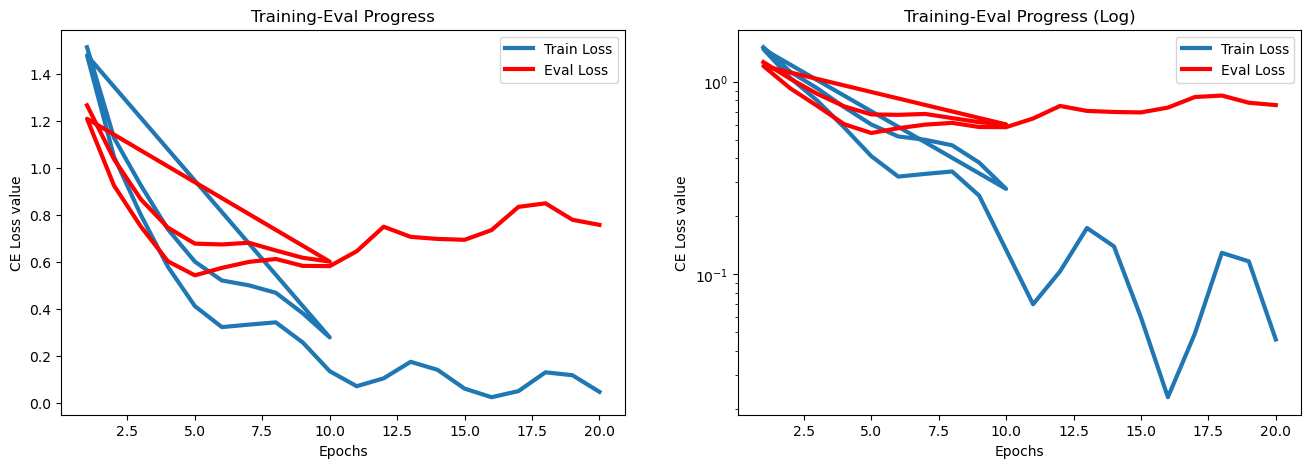

In [53]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,5)

for a in ax:

    a.plot(epochs+1, train_loss, label="Train Loss", linewidth=3)
    a.plot(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", label="Eval Loss", linewidth=3)
#     a.scatter(epochs[eval_idx]+1, eval_loss[eval_idx], c="red", s=100, marker="x")
    a.legend(loc="best")
    a.set_xlabel("Epochs")
    a.set_ylabel("CE Loss value")

ax[0].set_title("Training-Eval Progress")
ax[1].set_title("Training-Eval Progress (Log)")
ax[1].set_yscale("log")

plt.show()

In [ ]:
def custom_learning_rate_scheduler(optimizer, epoch, warmup_epochs=5, max_epochs=50, initial_lr=0.001):
    if epoch < warmup_epochs:
        lr = initial_lr * (epoch / warmup_epochs)
    else:
        lr = initial_lr * (1.0 - (epoch - warmup_epochs) / (max_epochs - warmup_epochs))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr